In [174]:
from caveclient import CAVEclient
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
client = CAVEclient('minnie65_phase3_v1')

In [3]:
client.materialize.get_tables()

['bodor_pt_cells',
 'column_excitatory_subgroups_pheno',
 'slant_data_subtypes',
 'proofreading_functional_coreg_v2',
 'proofreading_functional_coreg',
 'nucleus_neuron_svm',
 'functional_coreg',
 'allen_v1_column_thalamic',
 'allen_column_l5it_types',
 'allen_column_basket_molecular',
 'allen_column_bodor_surround_inhib',
 'proofreading_status_public_release',
 'func_unit_em_match_release',
 'aibs_column_nonneuronal',
 'pt_synapse_targets',
 'cg_cell_type_calls',
 'l5_mc_cg',
 'baylor_e_i_model_v1',
 'allen_neuron_nonneuron_svm_v0',
 'allen_class_type_svm_v0',
 'allen_subclass_type_svm_v0',
 'allen_v1_column_pyc_proof',
 'allen_v1_column_types_slanted',
 'allen_minnie_extra_types',
 'allen_v1_column_types_v3',
 'allen_v1_column_types_v2',
 'allen_v1_column_proofreading',
 'allen_soma_coarse_cell_class_model_v2',
 'allen_soma_coarse_cell_class_model_v1',
 'synapses_pni_2',
 'nucleus_detection_v0']

In [4]:
ct_df = client.materialize.query_table('allen_subclass_type_svm_v0')

In [9]:
np_df=ct_df.query('cell_type=="5P-NP"')

In [15]:
dfs=[]
for root_id in tqdm.notebook.tqdm(np_df.pt_root_id.values):
    syn_df = client.materialize.synapse_query(post_ids=root_id)
    dfs.append(syn_df)


  0%|          | 0/811 [00:00<?, ?it/s]

In [16]:
np_in_df = pd.concat(dfs)

In [293]:
ct_df

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,485509,t,aibs_coarse_excitatory,23P,103588564537113366,864691136740606812,"[282608, 103808, 20318]"
1,113721,t,aibs_coarse_excitatory,4P,79951332685465031,864691135366988025,"[110208, 153664, 23546]"
2,263203,t,aibs_coarse_excitatory,4P,87694643458256575,864691136194511948,"[166512, 174176, 24523]"
3,456177,t,aibs_coarse_excitatory,23P,102677963354799688,864691135337690598,"[275616, 135120, 24873]"
4,160102,t,aibs_coarse_excitatory,4P,82415956919533862,864691135162203437,"[128128, 166528, 24710]"
...,...,...,...,...,...,...,...
65153,394515,t,aibs_coarse_excitatory,5P-PT,96347181023422242,864691136050803443,"[229504, 152816, 20596]"
65154,390522,t,aibs_coarse_excitatory,23P,97749195318464441,864691135571211757,"[239920, 112864, 17348]"
65155,329229,t,aibs_coarse_excitatory,4P,92547130727975969,864691135740183915,"[202176, 151760, 15660]"
65156,256280,t,aibs_coarse_excitatory,23P,87546415009833381,864691136966016974,"[165808, 118256, 20198]"


In [27]:

nuc_nrn_df = client.materialize.query_table('nucleus_neuron_svm')
nrn_qc_df = client.materialize.query_table('allen_neuron_nonneuron_svm_v0',
                                           filter_equal_dict={'cell_type':'neuron'})
nuc_det_df = client.materialize.query_table('nucleus_detection_v0')

nuc_det_df=nuc_det_df.set_index('id')
nrn_qc_df=nrn_qc_df.set_index('id')
nuc_nrn_df=nuc_nrn_df.set_index('id')

dfm = pd.merge(nuc_nrn_df, nuc_det_df[['volume']], left_index=True, right_index=True, how='inner')
dfm = pd.merge(dfm, nrn_qc_df[['cell_type']], left_index=True, right_index=True, suffixes=['', '_qc'], how='left')

n_nuc_det=dfm.groupby('pt_root_id').valid.agg(len)
n_nuc_det.name='num_nuc_det'
n_neuron_det = dfm.query('cell_type =="neuron"').groupby('pt_root_id').valid.agg(len)
n_neuron_det.name='n_neuron_det'
n_neuron_qc = dfm.query('cell_type_qc =="neuron"').groupby('pt_root_id').valid.agg(len)
n_neuron_qc.name = 'n_neuron_qc'
nuc_count = pd.DataFrame([n_nuc_det, n_neuron_det, n_neuron_qc]).T

nuc_count.fillna(0, inplace=True)

In [43]:
np_in_dfm=pd.merge(np_in_df, nuc_count, left_on='pre_pt_root_id', right_index=True, how='left')

In [44]:
np_in_dfm['n_syn']=np_in_df.groupby('pre_pt_root_id')['size'].transform(len)


In [317]:
np_in_dfm

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,num_nuc_det,n_neuron_det,n_neuron_qc,n_syn
0,133918437,t,87133342033799034,864691135492357828,87133342033809946,864691135233329753,5144,"[162490, 186458, 18657]","[162464, 186538, 18662]","[162494, 186524, 18660]",NaN,NaN,NaN,2
1,248976834,t,96213521305707018,864691135029942943,96283821330396645,864691135233329753,3724,"[228872, 205558, 18118]","[228926, 205476, 18114]","[228885, 205506, 18117]",NaN,NaN,NaN,1
2,133947328,t,86714084505988746,864691136843313774,86714084506003909,864691135233329753,5944,"[159508, 208082, 18440]","[159546, 208108, 18451]","[159574, 208102, 18445]",NaN,NaN,NaN,1
3,217398726,t,93470789147794992,864691134043798731,93470789147799267,864691135233329753,8188,"[208752, 218054, 15294]","[208686, 218014, 15295]","[208688, 218002, 15287]",NaN,NaN,NaN,1
4,176108008,t,90231971959402745,864691135884129648,90161603215244603,864691135233329753,6600,"[184902, 204296, 18779]","[184786, 204254, 18780]","[184834, 204282, 18775]",NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,52475944,t,80803179117518184,864691136258554509,80803179117519152,864691135322945948,10808,"[116588, 208722, 21824]","[116488, 208764, 21825]","[116509, 208766, 21823]",NaN,NaN,NaN,2
369,68999615,t,82001578139438373,864691136293689054,82001509419990810,864691135322945948,13944,"[125268, 224500, 22320]","[125226, 224396, 22318]","[125216, 224462, 22321]",NaN,NaN,NaN,2
370,75888240,t,82564047123599257,864691134814622133,82564115843075015,864691135322945948,4536,"[129278, 221380, 22807]","[129388, 221430, 22813]","[129344, 221370, 22811]",NaN,NaN,NaN,1
371,75518316,t,82424409079527885,864691136262957965,82424409079507729,864691135322945948,7356,"[128246, 229256, 22079]","[128286, 229216, 22069]","[128371, 229240, 22072]",NaN,NaN,NaN,11


In [47]:
np_in_dfm2=np_in_dfm.sort_values('n_syn', ascending=False)

In [48]:
np_in_dfm3=np_in_dfm2.groupby('pre_pt_root_id').first()

In [49]:
np_in_dfm3.sort_values('n_syn', ascending=False)

,id,valid,pre_pt_supervoxel_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,num_nuc_det,n_neuron_det,n_neuron_qc,n_syn
pre_pt_root_id,,,,,,,,,,,,,
864691135122581543,306847394,t,100998390086684158,100998390086643758,864691135462705982,4972,"[263374, 204050, 20489]","[263378, 204120, 20482]","[263364, 204112, 20486]",1.0,1.0,1.0,343
864691136309922650,333186035,t,103462121438234476,103462121504780886,864691135064996164,5272,"[281286, 210404, 26106]","[281288, 210356, 26114]","[281245, 210339, 26106]",1.0,1.0,1.0,329
864691136116450724,138014052,t,87490408971799418,87420040227636125,864691136311845949,8184,"[164956, 225386, 22781]","[164888, 225324, 22786]","[164907, 225307, 22785]",1.0,1.0,1.0,326
864691135848174686,274071661,t,98185288916049147,98185288916049467,864691135407327433,5628,"[242894, 216266, 15475]","[242840, 216326, 15477]","[242890, 216312, 15484]",1.0,1.0,1.0,321
864691136390624383,256132845,t,97270839174990115,97270839175009581,864691136334231219,5432,"[236200, 219026, 18278]","[236238, 218996, 18284]","[236306, 218975, 18284]",1.0,1.0,1.0,317
...,...,...,...,...,...,...,...,...,...,...,...,...,...
864691135289724136,406449695,t,109374675557627083,109374744277090944,864691135445915282,6220,"[324526, 222330, 18907]","[324540, 222430, 18917]","[324524, 222388, 18910]",NaN,NaN,NaN,1
864691135289718027,231824515,t,94598545554030514,94598545554036893,864691135888744841,14560,"[216776, 231866, 23249]","[216658, 231924, 23256]","[216720, 231902, 23249]",NaN,NaN,NaN,1
864691135289716219,267058071,t,97957003686883783,98027372431079124,864691136109198776,2420,"[241642, 88504, 22292]","[241728, 88530, 22297]","[241686, 88462, 22300]",NaN,NaN,NaN,1


In [51]:
np_in_dfm.shape, np_in_dfm2.shape, np_in_dfm3.shape

((698806, 14), (698806, 14), (536690, 13))

In [58]:
np_in_dfm3[np_in_dfm3.num_nuc_det.isna()].sort_values('n_syn', ascending=False).index[0:20]

Int64Index([864691135446887252, 864691136901538926, 864691135771841981,
            864691135546569412, 864691136694784110, 864691136742628718,
            864691136931103199, 864691135919867233, 864691135485321909,
            864691136939303135, 864691136914933614, 864691135664344516,
            864691135635865796, 864691135737062804, 864691135682415812,
            864691135737014932, 864691135496534770, 864691136700407918,
            864691136900816238, 864691135988117410],
           dtype='int64', name='pre_pt_root_id')

Text(0, 0.5, 'number of synapses onto NP cells')

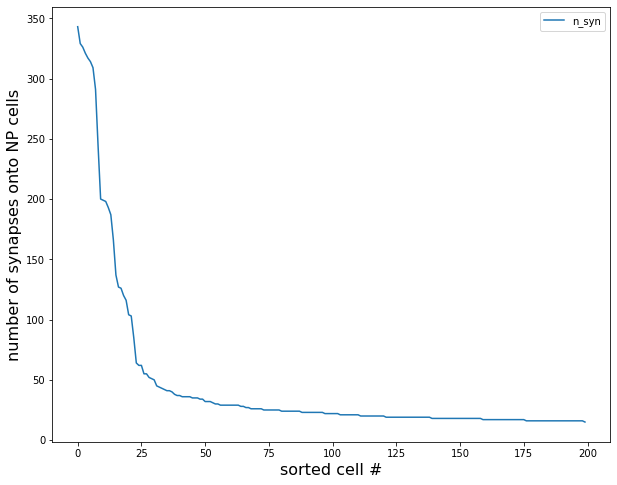

In [315]:
f, ax= plt.subplots(figsize=(10,8))
np_in_dfm3.query('n_neuron_qc==1').sort_values('n_syn', ascending=False).reset_index().iloc[0:200].plot(y='n_syn', ax=ax)
ax.set_xlabel('sorted cell #', size=16)
ax.set_ylabel('number of synapses onto NP cells', size=16)

In [470]:
top_targeters=np_in_dfm3.query('n_neuron_qc==0').sort_values('n_syn', ascending=False).iloc[0:50].index

In [471]:
now = datetime.datetime.utcnow()

In [474]:

# for top_t in top_targeters.values:
#     new_roots = client.chunkedgraph.get_latest_roots(int(top_t), timestamp_future=now)
#     if np.any(np.isin(new_roots, np_targeters)):
#         print('found')
#     else:
#         print(new_roots), top_t

In [475]:
# top_targeters.values

In [451]:
nuc_nrn_df = client.materialize.live_query(table='nucleus_neuron_svm',
                                           timestamp=now)
nrn_qc_df = client.materialize.live_query(table='allen_neuron_nonneuron_svm_v0',
                                           timestamp=now,
                                           filter_equal_dict={'cell_type':'neuron'})
nuc_det_df = client.materialize.live_query(table='nucleus_detection_v0',
                                           timestamp=now)

nuc_det_df=nuc_det_df.set_index('id')
nrn_qc_df=nrn_qc_df.set_index('id')
nuc_nrn_df=nuc_nrn_df.set_index('id')

dfm = pd.merge(nuc_nrn_df, nuc_det_df[['volume']], left_index=True, right_index=True, how='inner')
dfm = pd.merge(dfm, nrn_qc_df[['cell_type']], left_index=True, right_index=True, suffixes=['', '_qc'], how='left')

n_nuc_det=dfm.groupby('pt_root_id').valid.agg(len)
n_nuc_det.name='num_nuc_det'
n_neuron_det = dfm.query('cell_type =="neuron"').groupby('pt_root_id').valid.agg(len)
n_neuron_det.name='n_neuron_det'
n_neuron_qc = dfm.query('cell_type_qc =="neuron"').groupby('pt_root_id').valid.agg(len)
n_neuron_qc.name = 'n_neuron_qc'
nuc_count = pd.DataFrame([n_nuc_det, n_neuron_det, n_neuron_qc]).T

nuc_count.query('n_neuron_qc>0').n_neuron_det.value_counts()

1.0       68041
2.0         314
3.0          51
5.0          24
4.0          17
6.0          16
7.0           4
6813.0        1
181.0         1
Name: n_neuron_det, dtype: int64

In [452]:
np_targeter_nucs = [271700, 405628, 276351, 501303, 169323, 499104, 307287, 309052,
            341911, 304163, 342454, 593120, 717181, 236705, 305073, 434607,
            204928, 563979, 534621, 496423, 673262, 622509, 499161, 373907]


In [453]:
np_targeters=nuc_nrn_df.loc[np_targeter_nucs].pt_root_id.values

In [454]:
np.unique(np_targeters, return_counts=True)

(array([864691135082074359, 864691135100280096, 864691135118238685,
        864691135122581543, 864691135133072032, 864691135156022884,
        864691135233544281, 864691135307444038, 864691135355448783,
        864691135462656157, 864691135468031628, 864691135565064279,
        864691135754910930, 864691135815945039, 864691135841437923,
        864691135848174686, 864691135864497022, 864691135937597956,
        864691136041519446, 864691136084479084, 864691136089287735,
        864691136237120015, 864691136617451995, 864691136673168775]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]))

In [455]:
out_dfs = []
import datetime

for root_id in tqdm.notebook.tqdm(np_targeters):
    syn_df = client.materialize.synapse_query(pre_ids=root_id, timestamp=now)
    out_dfs.append(syn_df)

  0%|          | 0/24 [00:00<?, ?it/s]

In [456]:
out_df = pd.concat(out_dfs)

In [457]:
ct_df = client.materialize.query_table('allen_subclass_type_svm_v0', timestamp=now)


In [458]:
ss_ct=pd.merge(ct_df, nuc_count.query('n_neuron_det==1'), left_on='pt_root_id', right_index=True, how='inner')

In [459]:
ss_ct

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position,num_nuc_det,n_neuron_det,n_neuron_qc
0,485509,t,aibs_coarse_excitatory,23P,103588564537113366,864691136740606812,"[282608, 103808, 20318]",1.0,1.0,1.0
1,113721,t,aibs_coarse_excitatory,4P,79951332685465031,864691135366988025,"[110208, 153664, 23546]",1.0,1.0,1.0
2,263203,t,aibs_coarse_excitatory,4P,87694643458256575,864691136194511948,"[166512, 174176, 24523]",1.0,1.0,1.0
3,456177,t,aibs_coarse_excitatory,23P,102677963354799688,864691135337690598,"[275616, 135120, 24873]",1.0,1.0,1.0
4,160102,t,aibs_coarse_excitatory,4P,82415956919533862,864691135162203437,"[128128, 166528, 24710]",1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
65153,394515,t,aibs_coarse_excitatory,5P-PT,96347181023422242,864691136050803443,"[229504, 152816, 20596]",1.0,1.0,1.0
65154,390522,t,aibs_coarse_excitatory,23P,97749195318464441,864691135571211757,"[239920, 112864, 17348]",1.0,1.0,1.0
65155,329229,t,aibs_coarse_excitatory,4P,92547130727975969,864691135740183915,"[202176, 151760, 15660]",1.0,1.0,1.0
65156,256280,t,aibs_coarse_excitatory,23P,87546415009833381,864691136966016974,"[165808, 118256, 20198]",1.0,1.0,1.0


In [460]:
out_with_ct=pd.merge(out_df, ss_ct[['pt_root_id','id', 'cell_type']],
                     left_on='post_pt_root_id', right_on='pt_root_id')

In [461]:
cell_by_class=pd.pivot_table(out_with_ct[['pre_pt_root_id', 'cell_type']],
                             columns=['cell_type'], index='pre_pt_root_id', aggfunc=len)

In [462]:
syn_counts=np.sum(cell_by_class.fillna(0).values, axis=1)

In [463]:
M=cell_by_class.fillna(0).values.T/syn_counts.T

Text(0.5, 1.0, 'Synapse output fraction by cell sub-class')

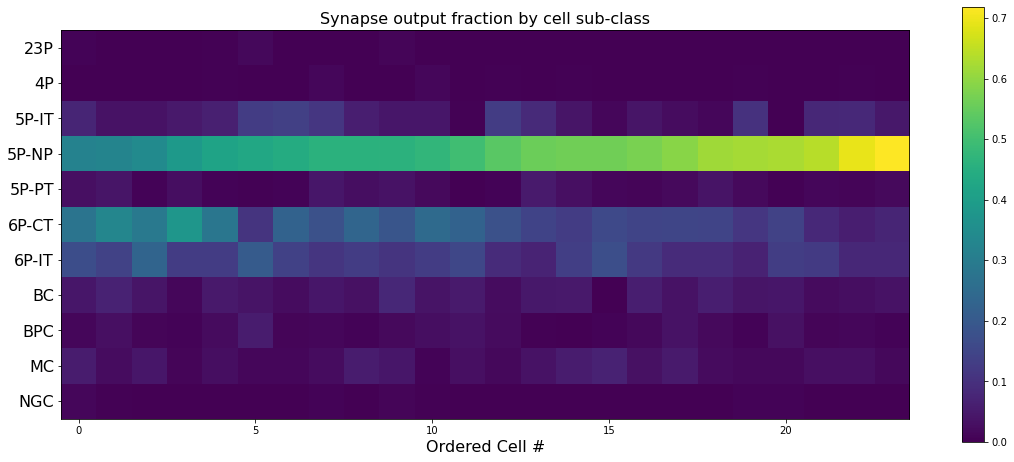

In [464]:
order = np.argsort(M[3,:])
f, ax = plt.subplots(figsize=(19,8))
h=ax.imshow(M[:,order])
f.colorbar(h)
ax.set_yticks(np.arange(M.shape[0]))
ax.set_yticklabels(cell_by_class.columns, size=16)
ax.set_xlabel('Ordered Cell #', size=16)
ax.set_title('Synapse output fraction by cell sub-class',size=16)

Text(0, 0.5, '% synapses onto sub-class')

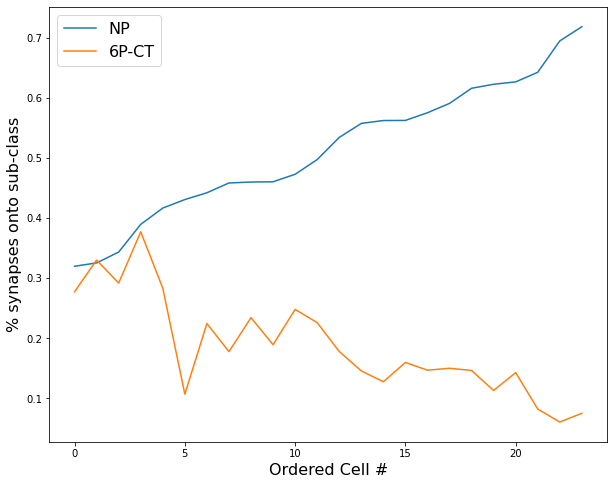

In [465]:
f, ax = plt.subplots(figsize=(10,8))
ax.plot(M.T[order,3])
ax.plot(M.T[order,5])
ax.legend(["NP","6P-CT"], fontsize=16)
ax.set_xlabel('Ordered Cell #', size=16)
ax.set_ylabel('% synapses onto sub-class', size=16)

Text(0.5, 0, 'Ordered Cell #')

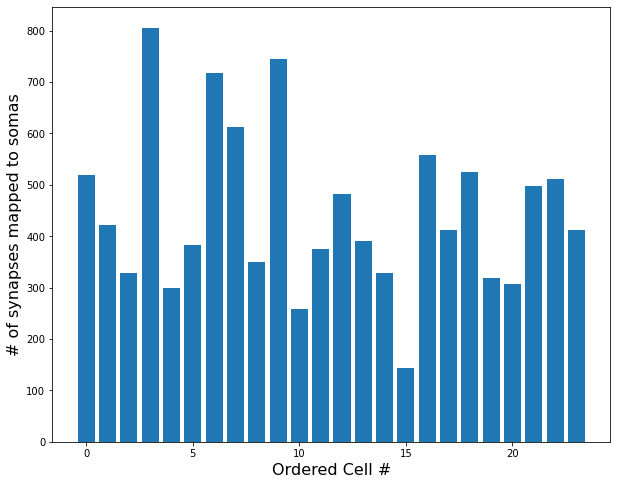

In [466]:
f, ax = plt.subplots(figsize=(10,8))
ax.bar(np.arange(0,len(syn_counts)),syn_counts[order])
ax.set_ylabel('# of synapses mapped to somas', size=16)
ax.set_xlabel('Ordered Cell #', size=16)


In [467]:
np.mean(syn_counts), np.std(syn_counts)

(446.1666666666667, 156.4650298167471)

In [468]:
cell_by_class.iloc[order,:].index[23]

864691135133072032